# Can we learn the weight of aggregation? 

First of all, get the data prepared and model prepared.

We use MNIST here

In [65]:
from Data import load_centralized_dataset
trainset, valset, testset = load_centralized_dataset(
    name='MNIST', validation_split=0.1, download=False)
print(f'Train Set: {len(trainset)}, Val Set: {len(valset)}, Test Set: {len(testset)}')


Loading MNIST dataset
Train Set: 54000, Val Set: 6000, Test Set: 10000


The setting is:
- Two same models
- One of them is trained on clean dataset 
- The another one is trained on noisy dataset
- Validation dataset is clean
- Having a metanet $\theta_{meta}(e, l)$
- Aggregate using the weight produced by metanet

In [66]:
from Data import ImbalancedNoisyDataWrapper
noisy_trainset = ImbalancedNoisyDataWrapper(
    base_dataset=trainset, num_classes=10, corruption_prob=0.3, imbalanced_ratio=0)
from Split import ClientWiseNoisySplitter
splitter = ClientWiseNoisySplitter(client_num=2, noisy_client_ids=[1])                                   

client 1 has flipped labels

In [67]:
clients_dataidx_map = splitter(noisy_trainset)

Client 1 has 14683 noisy samples
Splitting dataset into 2 clients.
{0: 19659, 1: 34341}


Let's start with a very basic model: ConvNet5 

In [68]:
from Model import ConvNet2, ConvNet5
model = ConvNet5(in_channels=1, class_num=10)

In [69]:
import torch
import torch.nn as nn
meta_net = nn.Sequential(nn.Linear(2, 100), nn.ReLU(), nn.Linear(100, 1))

Let's have a look at the initilization surface of the meta net

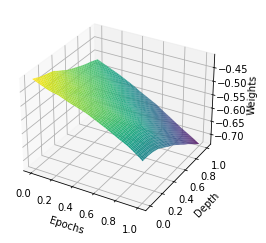

In [70]:
es = torch.linspace(0, 1, steps=100)
ls = torch.linspace(0, 1, steps=100)
e, l = torch.meshgrid(es, ls)
data = torch.dstack((e, l))
data = data.reshape(-1, 2)
with torch.no_grad():
    z = meta_net(data)
z = z.reshape(100, 100)
import matplotlib.pyplot as plt 
ax = plt.axes(projection='3d')
ax.plot_surface(e.numpy(), l.numpy(), z.numpy(), cmap='viridis', edgecolor='none')
ax.set_xlabel('Epochs')
ax.set_ylabel('Depth')
ax.set_zlabel('Weights')
plt.show()


---

let's start the training

In [71]:
import wandb
import os
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
saving_dir = 'learn-to-aggregate'
model0_dir = os.path.join(saving_dir, 'model0')
model1_dir = os.path.join(saving_dir, 'model1')
meta_net_dir = os.path.join(saving_dir, 'meta_net')
aggregated_model_dir = os.path.join(saving_dir, 'aggregated_model')
if not os.path.exists(saving_dir):
    os.makedirs(saving_dir)
if not os.path.exists(model0_dir):
    os.makedirs(model0_dir)
if not os.path.exists(model1_dir):
    os.makedirs(model1_dir)
if not os.path.exists(meta_net_dir):
    os.makedirs(meta_net_dir)
if not os.path.exists(aggregated_model_dir):
    os.makedirs(aggregated_model_dir)

In [63]:
cfg = {}
EPOCH = 100
BATCH_SIZE = 1024
BASE_LR = 0.001
META_LR = 0.001
WEIGHT_DECAY = 0.0004
MOMENTUM = 0.9
LOCAL_ROUND = 5
META_STEPS = 5
cfg['epoch'] = EPOCH
cfg['batch_size'] = BATCH_SIZE
cfg['base_lr'] = BASE_LR
cfg['meta_lr'] = META_LR
cfg['meta_steps'] = META_STEPS
cfg['weight_decay'] = WEIGHT_DECAY
cfg['momentum'] = MOMENTUM
cfg['local_round'] = LOCAL_ROUND

In [64]:
from tqdm import tqdm
import copy
import FedAvg
def train(cfg, trainsets, val_loader,  device):
    meta_loader_iter = iter(val_loader)
    epochs = cfg['epoch']
    batch_size = cfg['batch_size']
    base_lr = cfg['base_lr']
    meta_lr = cfg['meta_lr']
    momentum = cfg['momentum']
    weight_decay = cfg['weight_decay']
    local_round = cfg['local_round']
    print('Training Starts')
    meta_model = nn.Sequential(nn.Linear(2, 100), nn.ReLU(), nn.Linear(100, 1))
    meta_optimizer = torch.optim.Adam(meta_model.parameters(), lr=meta_lr)
    criterion = torch.nn.CrossEntropyLoss()
    for trainset in trainsets:
        base_model = ConvNet5(in_channels=1, class_num=10)
        base_optimizer = torch.optim.SGD(base_model, lr=base_lr, momentum=momentum, weight_decay=weight_decay)
        splitter = ClientWiseNoisySplitter(client_num=2, noisy_client_ids=[1])
        clients_dataidx_map = splitter(noisy_trainset)   
        for e in range(1, epochs+1):
            base_model.to(device)
            meta_model.to(device) 
            global_parmas = copy.deepcopy(base_model.state_dict())
            params_dict = dict.fromkeys(clients_dataidx_map.keys())
            for client in clients_dataidx_map.keys():
                data_idx = clients_dataidx_map[client]
                trainloader = torch.utils.data.DataLoader(
                    trainset, sampler=torch.utils.data.SubsetRandomSampler(data_idx),
                    BATCH_SIZE = batch_size)
                updated_params = FedAvg.local_train(
                    client, base_model, global_parmas, 
                    trainloader, base_optimizer, criterion, local_round, 
                    device)
                params_dict[client] = updated_params
        assert len(params_dict) == 2
        
        

                
                
            
            
        
    
        
    
    

SyntaxError: invalid syntax (2682171276.py, line 20)

In [75]:
model.parameters()

<generator object Module.parameters at 0x0000013B002102E0>

In [95]:
model0.state_dict().values()[0]

TypeError: 'odict_values' object is not subscriptable

In [117]:
import copy
from tkinter import W
model0 = nn.Linear(10, 1)
model1 = nn.Linear(10, 1)
model_global = nn.Linear(10, 1)
w = torch.tensor(2.0, requires_grad=True)
for param0, param1, param_global in zip(model0.state_dict().values(), model0.state_dict().values(), model_global.parameters()):
    param_global = (param0 + param1) / w
    print(param_global)
    print(w)
x = torch.ones(100, 10, requires_grad=True)
y = torch.zeros(100, 1, requires_grad=True)
out = model_global(x)
loss = torch.nn.functional.mse_loss(out, y)
grads = torch.autograd.grad(loss, (model_global.parameters()), create_graph=True)
print(grads)
print(next(model_global.parameters()))

tensor([[ 0.0322, -0.1856,  0.1061, -0.1951, -0.2407, -0.0847,  0.2280,  0.1167,
         -0.0264,  0.1547]], grad_fn=<DivBackward0>)
tensor(2., requires_grad=True)
tensor([-0.1370], grad_fn=<DivBackward0>)
tensor(2., requires_grad=True)
(tensor([[0.5068, 0.5068, 0.5068, 0.5068, 0.5068, 0.5068, 0.5068, 0.5068, 0.5068,
         0.5068]], grad_fn=<TBackward0>), tensor([0.5068], grad_fn=<ViewBackward0>))
Parameter containing:
tensor([[-0.1409,  0.2801,  0.2719,  0.2107,  0.0259, -0.2090,  0.2117, -0.1572,
          0.1396, -0.1901]], requires_grad=True)


In [ ]:
def meta_updating(params_dict, val_loader, meta_model, meta_optimizer, meta_steps):
    model0 = ConvNet5(in_channels=1, class_num=10).load_state_dict(
        params_dict[0])

    model1 = ConvNet5(in_channels=1, class_num=10).load_state_dict(
        params_dict[1])
    
    for step in range(meta_steps):
        meta_optimizer.zero_grad()
        loss = 0
        for client in params_dict.keys():
            for layer in params_dict[client].keys():
                loss += torch.sum((params_dict[client][layer] - meta_model(layer))**2)
        loss.backward()
        meta_optimizer.step()
    return meta_model